In [6]:
from astropy import constants as const
from astropy import units as u
import math
from astropy.io import fits
from astropy.wcs import WCS
# from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord  
from astropy.coordinates import FK5  
from photutils.aperture import SkyEllipticalAperture, SkyRectangularAperture
from photutils.aperture import aperture_photometry

## Define the constants and assumed abundances

In [7]:
X_1213 = 62.0
X_1218 = 540.0
X_1318 = 540.0/62.0
X_12CO = 1e-4
X_13CO = X_12CO/X_1213
X_C18O = X_12CO/X_1218
print(X_13CO/X_C18O)

8.709677419354838


In [8]:
h = const.h.value
k = const.k_B.value
pi = math.pi

## Load the fits files

<div style="font-size: 18px; line-height:1.5;">
  
We import the 12CO, 13CO and C18O fits cubes in this section. <br>
IMPORTANT: the fits cubes should have the same WCS axes. You can reproject the fits cubes using CASA.
  
</div>



In [9]:
dir_data = '/Users/donglinwu/Desktop/College/Research'

In [10]:
hdul_12CO = fits.open(dir_data+'/HOPS198_Data/HOPS198_CO_Tp12m7m_Combine_pbcor_masked.fits')
hdul_12CO.info()

hdu_12CO = hdul_12CO[0]
cube_12CO_header = hdu_12CO.header
cube_12CO_data = hdu_12CO.data

wcs_12CO = WCS(cube_12CO_header)

nu_o_12CO = cube_12CO_header['RESTFRQ']  #rest Frequency of 12CO(2-1) transition from header (in Hz)
bmaj_12CO = cube_12CO_header['BMAJ'] * 3600. #beam major axis (in arcsec)
bmin_12CO = cube_12CO_header['BMIN'] * 3600. #beam major axis (in arcsec)
dv_12CO = cube_12CO_header['CDELT3'] # velocity resolution (velocity channel spacing) in m/s
dx_12CO = cube_12CO_header['CDELT1'] # length of pixel (in degrees)
dy_12CO = cube_12CO_header['CDELT2'] # width of pixel (in degrees)

Filename: /Users/donglinwu/Desktop/College/Research/HOPS198_Data/HOPS198_CO_Tp12m7m_Combine_pbcor_masked.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      79   (448, 448, 1300)   float32   


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [131]:
hdul_13CO = fits.open(dir_data+'/HOPS198_Data/HOPS198_13CO_regrid_onto_12CO.fits')
hdul_13CO.info()

hdu_13CO = hdul_13CO[0]
cube_13CO_header = hdu_13CO.header
cube_13CO_data = hdu_13CO.data

wcs_13CO = WCS(cube_13CO_header)


nu_o_13CO = cube_13CO_header['RESTFRQ']  #rest Frequency of 13CO(2-1) transition from header (in Hz)
bmaj_13CO = cube_13CO_header['BMAJ'] * 3600. #beam major axis (in arcsec)
bmin_13CO = cube_13CO_header['BMIN'] * 3600. #beam major axis (in arcsec)
dv_13CO = cube_13CO_header['CDELT3'] # velocity resolution (velocity channel spacing) in m/s
dx_13CO = cube_13CO_header['CDELT1'] # length of pixel (in degrees)
dy_13CO = cube_13CO_header['CDELT2'] # width of pixel (in degrees)

Filename: /Users/donglinwu/Desktop/College/Research/HOPS198_Data/HOPS198_13CO_regrid_onto_12CO.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      75   (448, 448, 1300)   float32   


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [1]:
hdul_C18O = fits.open(dir_data+'/HOPS198_Data/HOPS198_C18O_regrid_onto_12CO.fits')
hdul_C18O.info()

hdu_C18O = hdul_C18O[0]
cube_C18O_header = hdu_C18O.header
cube_C18O_data = hdu_C18O.data

wcs_C18O = WCS(cube_C18O_header)


nu_o_C18O = cube_C18O_header['RESTFRQ']  #rest Frequency of C18O(2-1) transition from header (in Hz)
bmaj_C18O = cube_C18O_header['BMAJ'] * 3600. #beam major axis (in arcsec)
bmin_C18O = cube_C18O_header['BMIN'] * 3600. #beam major axis (in arcsec)
dv_C18O = cube_C18O_header['CDELT3'] # velocity resolution (velocity channel spacing) in m/s
dx_C18O = cube_C18O_header['CDELT1'] # length of pixel (in degrees)
dy_C18O = cube_C18O_header['CDELT2'] # width of pixel (in degrees)

## 5-sigma masks and brightness temperature

### Apply a 5-sigma mask

In [5]:
## [FUNCTION] extracts noise part of the spectrum
def noise_from_spectrum(spectrum, default_noise):
    # spectrum: the input spectrum
    # default_noise: a list of two indices; spectrum between these two indices is the useful
    #                spectrum outside these two indices is pure noise, which will be extracted by this function
    #                e.g. default_noise = [20, 80], spectrum[:20] and spectrum[80:] will be extracted and combined 
    noise = []
    for i in range (len(spectrum)):
        if i<default_noise[0] or i>default_noise[1]:
            if math.isnan(spectrum[i]) == False:
                noise.append(spectrum[i])
    return noise

In [6]:
## [INPUT]
## indices_noise_12CO: a list of two indices that define the range of the noise, see argument default_noise of the function noise_from_spectrum
indices_noise_12CO = [400,800]


# data_12CO: 12CO spectral cube (3d-array) after the mask is applied
# noise_12CO: an image (2d-array) of the std noise level for the 12CO spectral cube


data_12CO = np.zeros((cube_12CO_data.shape[0],cube_12CO_data.shape[1],cube_12CO_data.shape[2]),dtype=float)
noise_12CO = np.zeros((cube_12CO_data.shape[1],cube_12CO_data.shape[2]),dtype=float)
# area_12CO = np.zeros((cube_12CO_data.shape[0],cube_12CO_data.shape[1],cube_12CO_data.shape[2]),dtype=float)


for xchan in range(cube_12CO_data.shape[2]):
    for ychan in range(cube_12CO_data.shape[1]):
        spectrum = cube_12CO_data[:,ychan,xchan]
        vec_noise = noise_from_spectrum(spectrum, indices_noise_12CO)
        noise_12CO[ychan,xchan] = np.std(vec_noise)
        Mask = np.greater(spectrum,5*np.std(vec_noise))
        # area_12CO[:,ychan,xchan] = Mask.astype(int)
        data_12CO[:,ychan,xchan] = spectrum*Mask.astype(int)
        # if xchan % 100 == 0 and ychan % 100 == 0:
        #     print(xchan, ychan)



In [7]:
## [INPUT]
## indices_noise_13CO: a list of two indices that define the range of the noise, see argument default_noise of the function noise_from_spectrum
indices_noise_13CO = [540,655]


# data_13CO: 13CO spectral cube (3d-array) after the mask is applied
# noise_13CO: an image (2d-array) of the std noise level for the 13CO spectral cube


data_13CO = np.zeros((cube_13CO_data.shape[0],cube_13CO_data.shape[1],cube_13CO_data.shape[2]),dtype=float)
noise_13CO = np.zeros((cube_13CO_data.shape[1],cube_13CO_data.shape[2]),dtype=float)
# area_13CO = np.zeros((cube_13CO_data.shape[0],cube_13CO_data.shape[1],cube_13CO_data.shape[2]),dtype=float)

for xchan in range(cube_13CO_data.shape[2]):
    for ychan in range(cube_13CO_data.shape[1]):
        spectrum = cube_13CO_data[:,ychan,xchan]
        vec_noise = noise_from_spectrum(spectrum, indices_noise_13CO)
        noise_13CO[ychan,xchan] = np.std(vec_noise)
        Mask = np.greater(spectrum,5*np.std(vec_noise))
        data_13CO[:,ychan,xchan] = spectrum*Mask.astype(int)
        # area_13CO[:,ychan,xchan] = Mask.astype(int)



In [8]:
## [INPUT]
## indices_noise_C18O: a list of two indices that define the range of the noise, see argument default_noise of the function noise_from_spectrum
indices_noise_C18O = [0,650]

# data_C18O: C18O spectral cube (3d-array) after the mask is applied
# noise_C18O: an image (2d-array) of the std noise level for the C18O spectral cube

data_C18O = np.zeros((cube_C18O_data.shape[0],cube_C18O_data.shape[1],cube_C18O_data.shape[2]),dtype=float)
noise_C18O = np.zeros((cube_C18O_data.shape[1],cube_C18O_data.shape[2]),dtype=float)
# area_C18O = np.zeros((cube_C18O_data.shape[0],cube_C18O_data.shape[1],cube_C18O_data.shape[2]),dtype=float)

for xchan in range(cube_C18O_data.shape[2]):
    for ychan in range(cube_C18O_data.shape[1]):
        spectrum = cube_C18O_data[:,ychan,xchan]
        vec_noise = noise_from_spectrum(spectrum, indices_noise_C18O)
        noise_C18O[ychan,xchan] = np.std(vec_noise)
        Mask = np.greater(spectrum,5*np.std(vec_noise))
        data_C18O[:,ychan,xchan] = spectrum*Mask.astype(int)
        # area_C18O[:,ychan,xchan] = Mask.astype(int)



In [9]:
## [OPTIONAL]
## Save the masked spectral cube if necessary

# from astropy.io import fits
# hdu_output = fits.PrimaryHDU()
# hdu_output.data = data_12CO
# hdu_output.header = hdu_12CO.header
# hdu_output.writeto(dir_data+'/HOPS198/HOPS198_12CO_masked_5sigma.fits', overwrite=True) #, overwrite=True

In [10]:
# hdu_output = fits.PrimaryHDU()
# hdu_output.data = data_13CO
# hdu_output.header = hdu_13CO.header
# hdu_output.writeto(dir_data+'/HOPS198/HOPS198_13CO_regrid_onto_12CO_masked_5sigma.fits', overwrite=True) #, overwrite=True

In [11]:
# hdu_output = fits.PrimaryHDU()
# hdu_output.data = data_C18O
# hdu_output.header = hdu_C18O.header
# hdu_output.writeto(dir_data+'/HOPS198/HOPS198_C18O_regrid_onto_12CO_masked_5sigma.fits', overwrite=True) #, overwrite=True

### Convert the intensity to brightness temperature

In [152]:
## [FUNCTION] Converts the intensity Jy/beam to brightness temperautre (K)
def T_mb(I, nu, bmaj, bmin):
    # This function changes the intensity from Jy/beam to brightness temperautre (K)
    # I: intensity in Jy/beam
    # nu: frequency in Hz
    # bmin: beam minor axis (arcsec) 
    # bmax: beam major axis (arcsec)
    return 1.222*1e6*I/(((nu/1e9)**2)*bmaj*bmin) #K/beam

In [14]:
T_data_12CO = T_mb(data_12CO, nu_o_12CO, bmaj_12CO, bmin_12CO)
T_data_13CO = T_mb(data_13CO, nu_o_13CO, bmaj_13CO, bmin_13CO)
T_data_C18O = T_mb(data_C18O, nu_o_C18O, bmaj_C18O, bmin_C18O)

<div style="font-size: 18px; line-height:1.5;">
  
To avoid repeatedly calculating the masks and the brightness temperature over and over again, it is recommended to save the brightness temeprature spectral cubes after the first time of the calculation and then read from the files afterwards. This can be done using the following lines of codes.
  
</div>



In [15]:
# from astropy.io import fits
# hdu_output = fits.PrimaryHDU()
# hdu_output.data = T_data_12CO
# hdu_output.header = hdu_12CO.header
# hdu_output.header['BUNIT'] = 'K'
# hdu_output.writeto(dir_data+'/HOPS198/HOPS198_T_12CO_masked_5sigma.fits', overwrite=True) 

In [16]:
# hdu_output = fits.PrimaryHDU()
# hdu_output.data = T_data_13CO
# hdu_output.header = hdu_13CO.header
# hdu_output.header['BUNIT'] = 'K'
# hdu_output.writeto(dir_data+'/HOPS198/HOPS198_T_13CO_regrid_onto_12CO_masked_5sigma.fits', overwrite=True) 

In [17]:
# hdu_output = fits.PrimaryHDU()
# hdu_output.data = T_data_C18O
# hdu_output.header = hdu_C18O.header
# hdu_output.header['BUNIT'] = 'K'
# hdu_output.writeto(dir_data+'/HOPS198/HOPS198_T_C18O_regrid_onto_12CO_masked_5sigma.fits', overwrite=True) 

In [73]:
# hdu_12CO_5sigma = fits.open(dir_data+'/HOPS198/HOPS198_T_12CO_masked_5sigma.fits')[0]
# T_data_12CO = hdu_12CO_5sigma.data
# cube_12CO_header = hdu_12CO_5sigma.header
# wcs_12CO = WCS(cube_12CO_header)

# nu_o_12CO = cube_12CO_header['RESTFRQ']  #rest Frequency of C18O(2-1) transition from header (in Hz)
# bmaj_12CO = cube_12CO_header['BMAJ'] * 3600. #beam major axis (in arcsec)
# bmin_12CO = cube_12CO_header['BMIN'] * 3600. #beam major axis (in arcsec)
# dv_12CO = cube_12CO_header['CDELT3'] # velocity resolution (velocity channel spacing) in m/s
# dx_12CO = cube_12CO_header['CDELT1'] # length of pixel (in degrees)
# dy_12CO = cube_12CO_header['CDELT2'] # width of pixel (in degrees)

# hdu_13CO_5sigma = fits.open(dir_data+'/HOPS198/HOPS198_T_13CO_regrid_onto_12CO_masked_5sigma.fits')[0]
# T_data_13CO = hdu_13CO_5sigma.data

# cube_13CO_header = hdu_13CO_5sigma.header
# wcs_13CO = WCS(cube_13CO_header)


# nu_o_13CO = cube_13CO_header['RESTFRQ']  #rest Frequency of C18O(2-1) transition from header (in Hz)
# bmaj_13CO = cube_13CO_header['BMAJ'] * 3600. #beam major axis (in arcsec)
# bmin_13CO = cube_13CO_header['BMIN'] * 3600. #beam major axis (in arcsec)
# dv_13CO = cube_13CO_header['CDELT3'] # velocity resolution (velocity channel spacing) in m/s
# dx_13CO = cube_13CO_header['CDELT1'] # length of pixel (in degrees)
# dy_13CO = cube_13CO_header['CDELT2'] # width of pixel (in degrees)


# hdu_C18O_5sigma = fits.open(dir_data+'/HOPS198/HOPS198_T_C18O_regrid_onto_12CO_masked_5sigma.fits')[0]
# T_data_C18O = hdu_C18O_5sigma.data

# cube_C18O_header = hdu_C18O_5sigma.header

# wcs_C18O = WCS(cube_C18O_header)


# nu_o_C18O = cube_C18O_header['RESTFRQ']  #rest Frequency of C18O(2-1) transition from header (in Hz)
# bmaj_C18O = cube_C18O_header['BMAJ'] * 3600. #beam major axis (in arcsec)
# bmin_C18O = cube_C18O_header['BMIN'] * 3600. #beam major axis (in arcsec)
# dv_C18O = cube_C18O_header['CDELT3'] # velocity resolution (velocity channel spacing) in m/s
# dx_C18O = cube_C18O_header['CDELT1'] # length of pixel (in degrees)
# dy_C18O = cube_C18O_header['CDELT2'] # width of pixel (in degrees)


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [74]:
## v_12CO: velocity of the channels (for the spectral axis of the spectral cubes)
##         Since the spectral cubes should be projected onto the same WCS axes, only the 12CO one would be enough.

v_12CO = [wcs_12CO[:,224,224].pixel_to_world(i).value for i in range(T_data_12CO.shape[0])] 
# v_13CO = [wcs_13CO[:,224,224].pixel_to_world(i).value for i in range(cube_13CO_data.shape[0])] 
# v_C18O = [wcs_C18O[:,224,224].pixel_to_world(i).value for i in range(cube_C18O_data.shape[0])] 

## Creating masks for the outflow

In [70]:
## [INPUT]
## Fits files that define the masks for the outflows
## HOPS 198 has asymmetric outflows with quite different properties. Therefore, opacity correction is done for the lobes differently.

mask_12CO_13CO_b = fits.open(dir_data+'/HOPS198/outflow/HOPS198_mask_outflow_blueshifted.fits')[0].data
mask_12CO_13CO_r = fits.open(dir_data+'/HOPS198/outflow/HOPS198_mask_outflow_redshifted.fits')[0].data

## Ratio of brightness temperature between 13CO and C18O

In [77]:
## ratio_13CO_C18O: image (2d array) of the ratio of brightness temperature of the 13CO line to the C18O line

ratio_13CO_C18O = np.zeros((T_data_13CO.shape[0],T_data_13CO.shape[1],T_data_13CO.shape[2]),dtype=float)


for xchan in range(T_data_13CO.shape[2]):
    for ychan in range(T_data_13CO.shape[1]):      
        for vchan in range(T_data_13CO.shape[0]):
            if T_data_C18O[vchan, ychan, xchan] > 0:
                ratio_13CO_C18O[vchan, ychan, xchan] = T_data_13CO[vchan, ychan, xchan]/T_data_C18O[vchan, ychan, xchan]

ratio_13CO_C18O [ratio_13CO_C18O <= 0] = np.nan

Just like the brightness temperature fits cubes, saving and reading the files would save time.

In [38]:
# hdu_output = fits.PrimaryHDU()
# hdu_output.data = ratio_13CO_C18O
# hdu_output.header = hdu_13CO.header
# hdu_output.header['BUNIT'] = ''
# hdu_output.writeto(dir_data+'/HOPS198/outflow/HOPS198_ratio_13CO_to_C18O.fits')

In [78]:
# hdu_ratio_13CO_C18O = fits.open(dir_data+'/HOPS198/outflow/HOPS198_ratio_13CO_to_C18O.fits')[0]
# ratio_13CO_C18O = hdu_ratio_13CO_C18O.data

In [110]:
## beam_area: number of pixels per beam

beam_area = abs(bmaj_12CO*bmin_12CO*np.pi/4/(dx_12CO*dy_12CO*3600*3600))

In [111]:
## ratio_13CO_C18O_ave_b, ratio_13CO_C18O_ave_r: 
##       1d array
##       average ratio of brightness temperature of 13CO to C18O inn the corresponding masks (blueshifted, redshifted lobe) for each channel

## ratio_13CO_C18O_std_b, ratio_13CO_C18O_std_r: 
##       1d array
##       standard deviation in the ratio of brightness temperature of 13CO to C18O in the corresponding masks (blueshifted, redshifted lobe) for each channel
##          divided by the ratio between the number of non-NaN pixels in the masks and the number of pixels in the beam
##       It is divided by this ratio because we are using the average ratio across the entire masks, but there is spatial dependence of pixels in a beam.



ratio_13CO_C18O_ave_b = np.zeros(T_data_13CO.shape[0])
ratio_13CO_C18O_std_b = np.zeros(T_data_13CO.shape[0])

ratio_13CO_C18O_ave_r = np.zeros(T_data_13CO.shape[0])
ratio_13CO_C18O_std_r = np.zeros(T_data_13CO.shape[0])


for index_chan in range(T_data_13CO.shape[0]):

    ratio_masked_13CO_C18O_b = mask_12CO_13CO_b*ratio_13CO_C18O[index_chan,:,:]
    ratio_masked_13CO_C18O_b[ratio_masked_13CO_C18O_b <= 0] = np.nan

    ratio_13CO_C18O_ave_b[index_chan] = np.nanmean(ratio_masked_13CO_C18O_b)
    ratio_13CO_C18O_std_b[index_chan] = np.nanstd(ratio_masked_13CO_C18O_b)/np.sqrt(np.count_nonzero(~np.isnan(ratio_masked_13CO_C18O_b))/beam_area)



    ratio_masked_13CO_C18O_r = mask_12CO_13CO_r*ratio_13CO_C18O[index_chan,:,:]
    ratio_masked_13CO_C18O_r[ratio_masked_13CO_C18O_r <= 0] = np.nan

    ratio_13CO_C18O_ave_r[index_chan] = np.nanmean(ratio_masked_13CO_C18O_r)
    ratio_13CO_C18O_std_r[index_chan] = np.nanstd(ratio_masked_13CO_C18O_r)/np.sqrt(np.count_nonzero(~np.isnan(ratio_masked_13CO_C18O_r))/beam_area)


ratio_13CO_C18O_ave_b[ratio_13CO_C18O_ave_b == 0] = np.nan
ratio_13CO_C18O_ave_r[ratio_13CO_C18O_ave_r == 0] = np.nan



/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_41368/1451100285.py:24: RuntimeWarning: Mean of empty slice
  ratio_13CO_C18O_ave_b[index_chan] = np.nanmean(ratio_masked_13CO_C18O_b)
/Users/donglinwu/anaconda3/envs/VSCode/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_41368/1451100285.py:32: RuntimeWarning: Mean of empty slice
  ratio_13CO_C18O_ave_r[index_chan] = np.nanmean(ratio_masked_13CO_C18O_r)


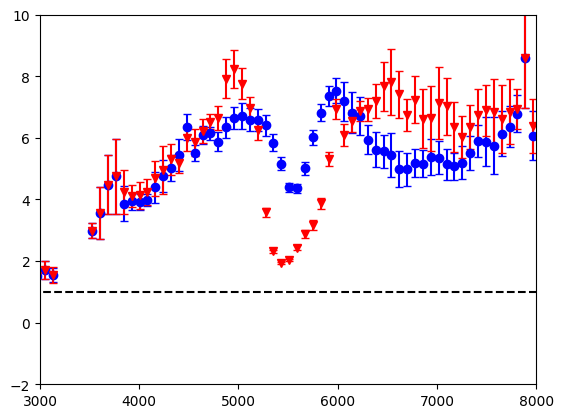

In [112]:
## Plots the average ratio for each of the corresponding lobe

plt.errorbar(v_12CO, ratio_13CO_C18O_ave_b, yerr=ratio_13CO_C18O_std_b, fmt='o', color='blue', capsize=3)
plt.errorbar(v_12CO, ratio_13CO_C18O_ave_r, yerr=ratio_13CO_C18O_std_r, fmt='v', color='red', capsize=3)
plt.xlim(3e3,8e3)
plt.ylim(-2,10)
plt.hlines(y=1, xmin=1e3, xmax=1.2e4, linestyles='dashed', color='black')

## Do quadratic fit for 13CO

### Left lobe

Channel number of minimum ratio near cloud velocity = 21


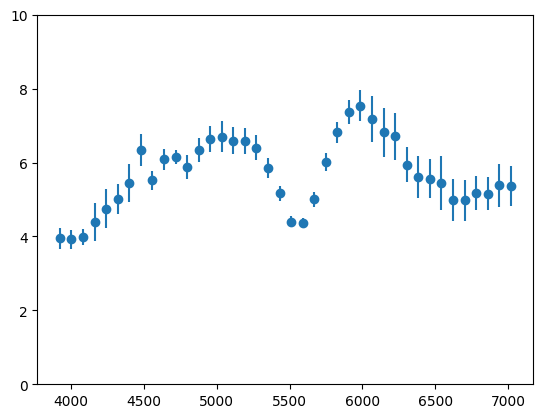

In [113]:
## Based on Cheng-han's code
## Plots the ratio of the brightness temperature around cloud velocity

#list values around cloud velocity, get channels (index) by looking at data cube
centralchan = 589 # check cube to see which is central channnel
chanwidth = 20 # number of channels below and above "central" channel (to include in the plots)
minchan = centralchan - chanwidth
maxchan = centralchan + chanwidth


plt.errorbar(v_12CO[minchan:maxchan],ratio_13CO_C18O_ave_b[minchan:maxchan],yerr=ratio_13CO_C18O_std_b[minchan:maxchan],label='data', fmt='o')
#plt.xlim(6, 10)
plt.ylim(0,10)
# plt.hlines(y=1, xmin=v_12CO[minchan], xmax=v_12CO[minchan], linestyles='dashed', color='black')

# show channel with minimum ratio around cloud velocity 
print('Channel number of minimum ratio near cloud velocity =',np.argmin(ratio_13CO_C18O_ave_b[minchan:maxchan])+chanwidth)

## [OPTIONAL]
## list ratios at velocities 
## ratio_13CO_C18O_ave_b[minchan:maxchan]

In [114]:
from scipy.optimize import curve_fit

def quadratic(x,a,b,c):
    return a*(x-b)**2+c

centralchan = 589
x1 = int(centralchan - 6)
x2 = int(centralchan - 0)  #remember in python [x1:x2] means x1 to x2-1
x3 = int(centralchan + 0)
x4 = int(centralchan + 7)


## x_forfit, y_forfit: velocity and ratio of brightness temperature (between 13CO and C18O) for each channel
## sig_forfit: can be regarded as an uncertainty in the ratio
##             computed as the standard deviation of the ratio of brightness temperature 
##                  divided by the ratio between the number of non-NaN pixels in the masks and the number of pixels in the beam

x_forfit = np.concatenate((np.array(v_12CO[x1:x2]), np.array(v_12CO[x3:x4])), axis=0) 
y_forfit = np.concatenate((ratio_13CO_C18O_ave_b[x1:x2], ratio_13CO_C18O_ave_b[x3:x4]), axis=0)
sig_forfit = np.concatenate((ratio_13CO_C18O_std_b[x1:x2], ratio_13CO_C18O_std_b[x3:x4]), axis=0)

popt_b_13CO_C18O,pcov_b_13CO_C18O = curve_fit(quadratic,x_forfit,y_forfit,sigma=sig_forfit,p0=[1.0,5500,1.0],bounds=([0, 5500,-np.inf],[np.inf,5560,np.inf]))  #sigma=sig_forfit


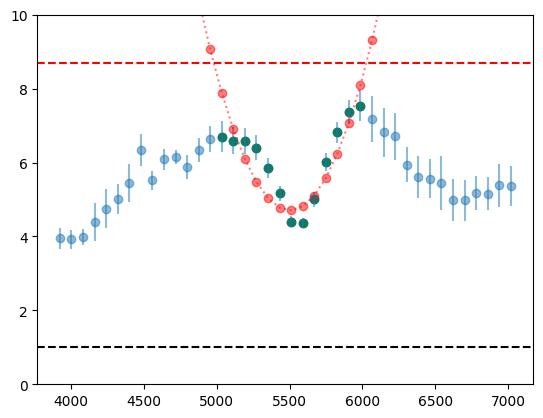

[1.44988425e-05 5.50290780e+03 4.70527608e+00]
[2.51263143e-06 2.56703400e+01 1.93535294e-01]


In [115]:
## Plot the best-fit parabola with the data

#plt.scatter(velo[367:383],spectrum_avg_b[367:383],label='data')
plt.scatter(x_forfit,y_forfit,color='green')
plt.errorbar(v_12CO[minchan:maxchan],ratio_13CO_C18O_ave_b[minchan:maxchan],yerr=ratio_13CO_C18O_std_b[minchan:maxchan],label='data', fmt='o', alpha=0.5)
plt.plot(v_12CO[minchan:maxchan],quadratic(v_12CO[minchan:maxchan],*popt_b_13CO_C18O),'ro:',label='fit',alpha=0.5)
plt.axhline(8.7,color='r',linestyle='--')
plt.axhline(1,color='black',linestyle='--')
plt.ylim(0,10)
plt.show()
print(popt_b_13CO_C18O)
print(np.sqrt(np.diagonal(pcov_b_13CO_C18O)))

(4000.0, 7000.0)

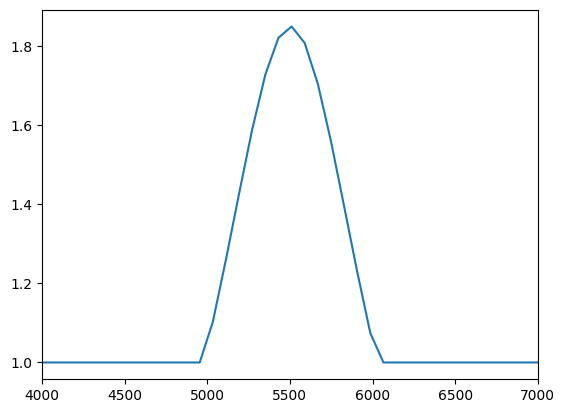

In [116]:
## corr_fac13co_b: the correction factor that corrects the brightness temperature of 13CO for opacity

corr_fac13co_b = np.zeros((ratio_13CO_C18O_ave_b.shape[0]),dtype=float)

for i in range(ratio_13CO_C18O_ave_b.shape[0]):
    r = quadratic(v_12CO[i],*popt_b_13CO_C18O)
    if r < 1.0:
        Ratio = 1.0
    elif r < 8.7:
        Ratio = r
    else:
        Ratio = 8.7
    corr_fac13co_b[i] = 1/(Ratio/8.7)

plt.plot(v_12CO,corr_fac13co_b)
plt.xlim(4e3,7e3)

### Right lobe

Just like the left lobe

Channel number of minimum ratio near cloud velocity = 21


array([4.10813602, 4.14115677, 4.23883603, 4.68320239, 4.97264805,
       5.29966978, 5.1873728 , 5.99441853, 5.85323725, 6.2220735 ,
       6.52647724, 6.64241137, 7.92284672, 8.24867846, 7.75804378,
       6.98017324, 6.24230534, 3.57730883, 2.31607189, 1.94900647,
       2.02378284, 2.43844241, 2.87807092, 3.17049676, 3.87264604,
       5.3196791 , 6.92701003, 6.09294109, 6.54567472, 6.86720083,
       6.92412581, 7.19563495, 7.67152265, 7.81848572, 7.41110941,
       6.74306398, 7.24224468, 6.62541016, 6.63515614, 7.13523801])

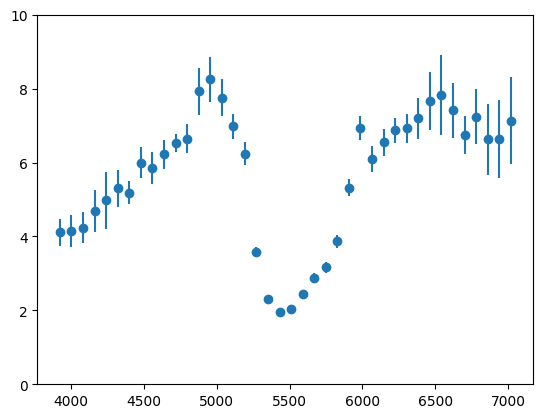

In [117]:
#list values around cloud velocity, get channels (index) by looking at data cube
centralchan = 589 # check cube to see which is central channnel
chanwidth = 20 # number of channels below and above "central" channel
minchan = centralchan - chanwidth
maxchan = centralchan + chanwidth

#first plot them
plt.errorbar(v_12CO[minchan:maxchan],ratio_13CO_C18O_ave_r[minchan:maxchan],yerr=ratio_13CO_C18O_std_r[minchan:maxchan],label='data', fmt='o')
# plt.errorbar(v_13CO[centralchan-5:centralchan+6],ratio_13CO_C18O_ave_b[centralchan-5:centralchan+6],yerr=ratio_13CO_C18O_std_b[centralchan-5:centralchan+6],label='cloud', fmt='o', color='red', alpha=0.5)
#plt.xlim(6, 10)
plt.ylim(0,10)
# plt.hlines(y=1, xmin=v_12CO[minchan], xmax=v_12CO[minchan], linestyles='dashed', color='black')

# show channel with minimum ration around cloud velocity 
print('Channel number of minimum ratio near cloud velocity =',np.argmin(ratio_13CO_C18O_ave_b[minchan:maxchan])+chanwidth)
#list ratios at velocities 
ratio_13CO_C18O_ave_r[minchan:maxchan]

In [118]:
from scipy.optimize import curve_fit

def quadratic(x,a,b,c):
    return a*(x-b)**2+c

centralchan = 589
x1 = int(centralchan - 7)
x2 = int(centralchan - 0)  #remember in python [x1:x2] means x1 to x2-1
x3 = int(centralchan + 0)
x4 = int(centralchan + 14)

x_forfit = np.concatenate((np.array(v_12CO[x1:x2]), np.array(v_12CO[x3:x4])), axis=0) 
y_forfit = np.concatenate((ratio_13CO_C18O_ave_r[x1:x2], ratio_13CO_C18O_ave_r[x3:x4]), axis=0)
sig_forfit = np.concatenate((ratio_13CO_C18O_std_r[x1:x2], ratio_13CO_C18O_std_r[x3:x4]), axis=0)

popt_r_13CO_C18O,pcov_r_13CO_C18O = curve_fit(quadratic,x_forfit,y_forfit,sigma=sig_forfit,p0=[1.0,5500,1.0],bounds=([0, 5500,-np.inf],[np.inf,5560,np.inf]))  #sigma=sig_forfit


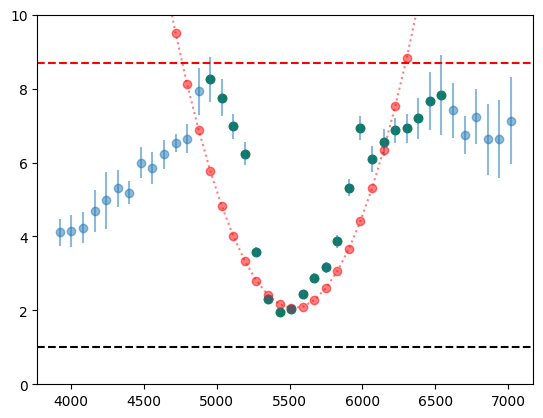

[1.12909675e-05 5.52940800e+03 2.05538512e+00]
[2.07416307e-06 4.31287606e+01 1.44425938e-01]


In [119]:
#plt.scatter(velo[367:383],spectrum_avg_b[367:383],label='data')
plt.scatter(x_forfit,y_forfit,color='green')
plt.errorbar(v_12CO[minchan:maxchan],ratio_13CO_C18O_ave_r[minchan:maxchan],yerr=ratio_13CO_C18O_std_r[minchan:maxchan],label='data', fmt='o', alpha=0.5)
plt.plot(v_12CO[minchan:maxchan],quadratic(v_12CO[minchan:maxchan],*popt_r_13CO_C18O),'ro:',label='fit',alpha=0.5)
plt.axhline(8.7,color='r',linestyle='--')
plt.axhline(1,color='black',linestyle='--')
plt.ylim(0,10)
plt.show()
print(popt_r_13CO_C18O)
print(np.sqrt(np.diagonal(pcov_r_13CO_C18O)))

(4000.0, 7000.0)

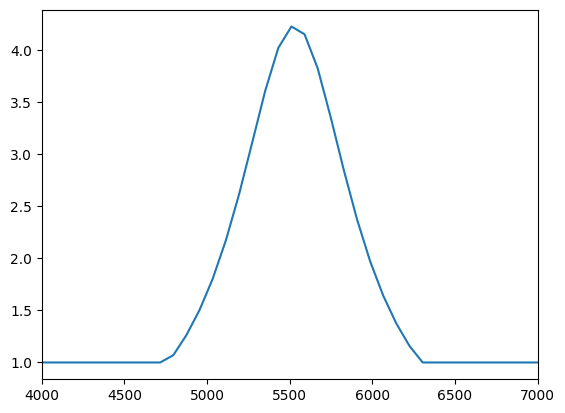

In [120]:
corr_fac13co_r = np.zeros((ratio_13CO_C18O_ave_r.shape[0]),dtype=float)

for i in range(ratio_13CO_C18O_ave_r.shape[0]):
    r = quadratic(v_12CO[i],*popt_r_13CO_C18O)
    if r < 1.0:
        Ratio = 1.0
    elif r < 8.7:
        Ratio = r
    else:
        Ratio = 8.7
    corr_fac13co_r[i] = 1/(Ratio/8.7)

plt.plot(v_12CO,corr_fac13co_r)
plt.xlim(4e3,7e3)

### Opacity correction on 13CO data

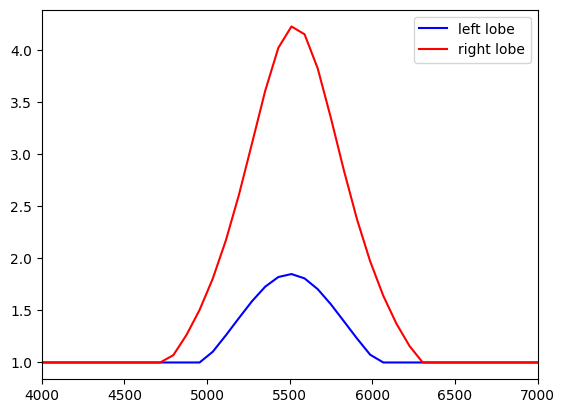

In [121]:
## The correction factor for the two lobes

plt.plot(v_12CO,corr_fac13co_b,color='blue',label='left lobe')
plt.plot(v_12CO,corr_fac13co_r,color='red',label='right lobe')
plt.xlim(4e3,7e3)
plt.legend()

In [122]:
## T_corr_13CO: opacity corrected 13CO fits cube

T_corr_13CO = np.zeros(shape=T_data_13CO.shape,dtype=float)

In [123]:
def distance_from_line(image, point1, point2):
    """
    Calculate the distance from each non-NaN, nonzero pixel to the extended line
    connecting two points and return a 2D array with distances and pixel values.
    Distances are negative for points to the left of the line and positive for points to the right.

    Parameters:
    image (2D array): The input image.
    point1 (tuple): Pixel coordinates of the first point (x1, y1).
    point2 (tuple): Pixel coordinates of the second point (x2, y2).

    Returns:
    distances_and_values (2D array): Each row contains the distance to the line and the pixel value.
    """
    # Unpack the points
    x1, y1 = point1
    x2, y2 = point2
    
    # Determine the orientation of the line
    orientation = np.sign((x2 - x1) * (y2 - y1))
    # print(orientation)
    
    # Find the non-NaN, nonzero pixels in the image
    non_nan_nonzero_pixels = np.argwhere((~np.isnan(image)) & (image != 0))
    
    distances_and_values = []
    
    for y, x in non_nan_nonzero_pixels:
        # Calculate the distance from the pixel to the line
        distance = ((x - x1) * (y2 - y1) - (y - y1) * (x2 - x1))
        # /np.sqrt(pow(x2-x1,2)+pow(y2-y1,2))
        distance *= orientation
        
        # Get the pixel value
        pixel_value = image[y, x]
        
        # Append the result as a row
        distances_and_values.append([distance, pixel_value])
    
    return np.array(distances_and_values)

# Example usage
# Assuming you have an image and two points:
# image = np.array([[0, 1, 2], [3, 4, np.nan], [6, 7, 8]])
# point1 = (0, 0)
# point2 = (2, 2)
# result = distance_from_line(image, point1, point2)
# print(result)


In [125]:
def fill_pixels(image, point1, point2, distribution_function):
    """
    Fill the pixels in the image with values based on a distribution function and their distance from the line.
    Only pixels with original value 0 will be filled.

    Parameters:
    image (2D array): The input image.
    point1 (tuple): Pixel coordinates of the first point (x1, y1).
    point2 (tuple): Pixel coordinates of the second point (x2, y2).
    distribution_function (function): A function that describes the distribution of pixel values with respect to distance.

    Returns:
    filled_image (2D array): The image with filled pixel values.
    """
    # Unpack the points
    x1, y1 = point1
    x2, y2 = point2
    
    # Calculate the orientation of the line
    orientation = np.sign((x2 - x1) * (y2 - y1))
    image_new = np.copy(image)
    # Iterate over each pixel in the image
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # Check if the original pixel value is 0
            if image[y, x] == True:
                # Calculate the distance from the pixel to the line
                distance = ((x - x1) * (y2 - y1) - (y - y1) * (x2 - x1))
                # /np.sqrt(pow(x2-x1,2)+pow(y2-y1,2))
                distance *= orientation

                # Interpolate the pixel value based on the distribution function and distance
                interpolated_value = distribution_function(distance)
                
                # Fill the pixel with the interpolated value
                image_new[y, x] = interpolated_value
    
    return image_new

# Example usage
# Assuming you have an image and two points:
# image = np.zeros((100, 100))  # Initialize with zeros
# point1 = (20, 20)
# point2 = (80, 80)
# distribution_function = lambda distance: 100 - distance  # Example linear distribution
# filled_image = fill_pixels(image, point1, point2, distribution_function)
# print(filled_image)


<div style="font-size: 16px; line-height:1.5;">
  
The following chunk of code is incomplete. <br>
vec_dis, region_central, c1_pixel, c2_pixel, mask_rline, mask_lline are defined when the outflow masks are created. However, they are not important here.  <br>
<br>
What the following chunk is doing is to correct the blueshifted and redshifted lobes for opacity using the different factors obtained above. However, to make sure the figure/data is smooth, the central region (overlapping region of the masks of the two lobes) are corrected using an linear interpolation of the correction factor through the region.<br>
<br>

The import thing is to run a loop through all the channels and multiply: brightness temperature of 13CO with the correction factor computed previously.
  
</div>



In [126]:
from scipy.interpolate import interp1d

for vchan in range(T_data_13CO.shape[0]):
    vec_fac_corr = np.array([corr_fac13co_r[vchan],corr_fac13co_r[vchan], corr_fac13co_b[vchan],corr_fac13co_b[vchan]])
    distribution_function = interp1d(vec_dis, vec_fac_corr,kind='cubic')
    fac_corr_central = fill_pixels(region_central, c1_pixel, c2_pixel, distribution_function)
    T_corr_13CO[vchan,:,:] = T_data_13CO[vchan,:,:]*np.logical_not(mask_rline)*corr_fac13co_b[vchan] + T_data_13CO[vchan,:,:]*np.logical_not(mask_lline)*corr_fac13co_r[vchan] + T_data_13CO[vchan,:,:]*mask_lline*mask_rline*fac_corr_central
    # T_corr_13CO[vchan,:,:] = T_data_13CO[vchan,:,:]*np.logical_not(mask_rline)*corr_fac13co_b[vchan] + T_data_13CO[vchan,:,:]*np.logical_not(mask_lline)*corr_fac13co_r[vchan] + T_data_13CO[vchan,:,:]*mask_lline*mask_rline*(corr_fac13co_b[vchan] + corr_fac13co_r[vchan])/2

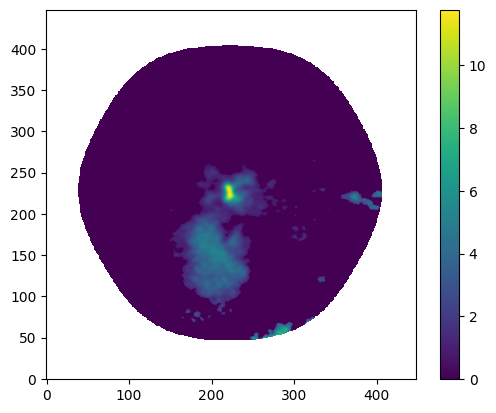

In [127]:
plt.imshow(T_corr_13CO[580,:,:],origin='lower')
plt.colorbar()

In [133]:
## Save the opacity corrected 13CO data if necessary

# from astropy.io import fits

# hdu_output = fits.PrimaryHDU()
# hdu_output.data = T_corr_13CO
# hdu_output.header = hdu_13CO.header
# hdu_output.writeto(dir_data+'/HOPS198/outflow/HOPS198_13CO_outflow_opacity_corrected_250522.fits', overwrite=True) #, overwrite=True

## Ratio of brightness temperature between 12CO and 13CO

In [57]:
## Read the opacity corrected 13CO data from the files if necessary

# hdu_T_corr_13CO = fits.open(dir_data+'/HOPS198/outflow/HOPS198_13CO_outflow_opacity_corrected_250522.fits')[0]
# T_corr_13CO = hdu_T_corr_13CO.data

In [134]:
from scipy.interpolate import interp1d
ratio_12CO_13CO = np.zeros((T_data_13CO.shape[0],T_data_13CO.shape[1],T_data_13CO.shape[2]),dtype=float)

for xchan in range(T_corr_13CO.shape[2]):
    for ychan in range(T_corr_13CO.shape[1]): 
        for vchan in range(T_corr_13CO.shape[0]):
            if T_corr_13CO[vchan, ychan, xchan] > 0:
                ratio_12CO_13CO[vchan, ychan, xchan] = T_data_12CO[vchan,ychan,xchan]/T_corr_13CO[vchan, ychan, xchan]

ratio_12CO_13CO [ratio_12CO_13CO <= 0] = np.nan

Just like the brightness temperature fits cubes, saving and reading the files would save time.

In [135]:
# hdu_output = fits.PrimaryHDU()
# hdu_output.data = ratio_12CO_13CO
# hdu_output.header = hdu_13CO.header
# hdu_output.header['BUNIT'] = ''
# hdu_output.writeto(dir_data+'/HOPS198/outflow/HOPS198_ratio_12CO_to_13CO_250522.fits') #, overwrite=True

In [136]:
# hdu_ratio_12CO_13CO = fits.open(dir_data+'/HOPS198/outflow/HOPS198_ratio_12CO_to_13CO_250522.fits')[0]
# ratio_12CO_13CO = hdu_ratio_12CO_13CO.data

In [137]:
## ratio_12CO_13CO_ave_b, ratio_12CO_13CO_ave_r: 
##       1d array
##       average ratio of brightness temperature of 12CO to 13CO in the corresponding masks (blueshifted, redshifted lobe) for each channel

## ratio_12CO_13CO_std_b, ratio_13CO_13CO_std_r: 
##       1d array
##       standard deviation in the ratio of brightness temperature of 12CO to 13CO in the corresponding masks (blueshifted, redshifted lobe) for each channel
##          divided by the ratio between the number of non-NaN pixels in the masks and the number of pixels in the beam
##       It is divided by this ratio because we are using the average ratio across the entire masks, but there is spatial dependence of pixels in a beam.


ratio_12CO_13CO_ave_b = np.zeros(T_data_13CO.shape[0])

ratio_12CO_13CO_std_b = np.zeros(T_data_13CO.shape[0])

ratio_12CO_13CO_ave_r = np.zeros(T_data_13CO.shape[0])

ratio_12CO_13CO_std_r = np.zeros(T_data_13CO.shape[0])



for index_chan in range(T_data_13CO.shape[0]):
    ratio_masked_12CO_13CO_b = mask_12CO_13CO_b*ratio_12CO_13CO[index_chan,:,:]
    ratio_masked_12CO_13CO_b[ratio_masked_12CO_13CO_b <= 0] = np.nan

    ratio_12CO_13CO_ave_b[index_chan] = np.nanmean(ratio_masked_12CO_13CO_b)
    ratio_12CO_13CO_std_b[index_chan] = np.nanstd(ratio_masked_12CO_13CO_b)/np.sqrt(np.count_nonzero(~np.isnan(ratio_masked_12CO_13CO_b))/beam_area)

    ratio_masked_12CO_13CO_r = mask_12CO_13CO_r*ratio_12CO_13CO[index_chan,:,:]
    ratio_masked_12CO_13CO_r[ratio_masked_12CO_13CO_r <= 0] = np.nan

    ratio_12CO_13CO_ave_r[index_chan] = np.nanmean(ratio_masked_12CO_13CO_r)
    ratio_12CO_13CO_std_r[index_chan] = np.nanstd(ratio_masked_12CO_13CO_r)/np.sqrt(np.count_nonzero(~np.isnan(ratio_masked_12CO_13CO_r))/beam_area)



/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_41368/2220447666.py:15: RuntimeWarning: Mean of empty slice
  ratio_12CO_13CO_ave_b[index_chan] = np.nanmean(ratio_masked_12CO_13CO_b)
/Users/donglinwu/anaconda3/envs/VSCode/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_41368/2220447666.py:21: RuntimeWarning: Mean of empty slice
  ratio_12CO_13CO_ave_r[index_chan] = np.nanmean(ratio_masked_12CO_13CO_r)


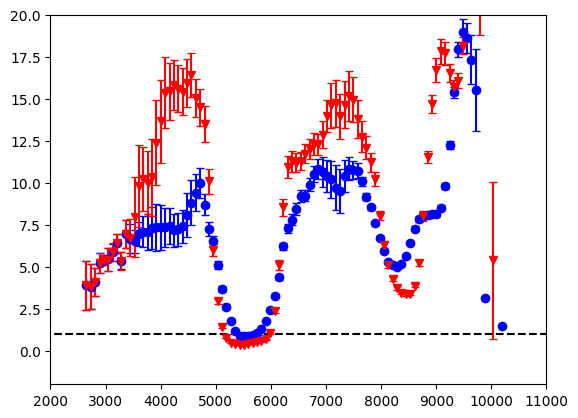

In [138]:
plt.errorbar(v_12CO, ratio_12CO_13CO_ave_b, yerr=ratio_12CO_13CO_std_b, fmt='o', color='blue', capsize=3)
plt.errorbar(v_12CO, ratio_12CO_13CO_ave_r, yerr=ratio_12CO_13CO_std_r, fmt='v', color='red', capsize=3)
plt.xlim(2e3, 1.1e4)
plt.ylim(-2,20)
plt.hlines(y=1, xmin=1e3, xmax=1.2e4, linestyles='dashed', color='black')

## Do quadratic fit for 12CO

Just like 13CO, comments omitted.

### Left lobe

Channel number of minimum ratio near cloud velocity = 40


array([ 7.33755371,  7.33215038,  7.33430705,  7.42505713,  7.16291798,
        7.23240943,  7.39755079,  8.05098248,  8.81999436,  9.4074588 ,
        9.99012783,  8.69249756,  7.23335568,  6.51360427,  5.09355147,
        3.68361201,  2.62826199,  1.75233295,  1.18321348,  0.88556752,
        0.85225397,  0.8904363 ,  0.96019378,  1.03920451,  1.26263107,
        1.75373707,  2.39771854,  3.25825802,  4.37644632,  6.21626244,
        7.29164457,  7.79676043,  8.4409513 ,  9.18803378,  9.22706801,
        9.88214349, 10.49516408, 10.82565967, 10.62635662, 10.40167422])

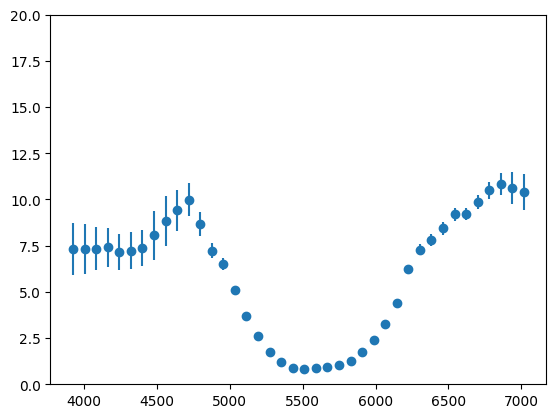

In [139]:
#list values around cloud velocity, get channels (index) by looking at data cube

centralchan = 589 # check cube to see which is central channnel
chanwidth = 20 # number of channels below and above "central" channel
minchan = centralchan - chanwidth
maxchan = centralchan + chanwidth

#first plot them
plt.errorbar(v_12CO[minchan:maxchan],ratio_12CO_13CO_ave_b[minchan:maxchan],yerr=ratio_12CO_13CO_std_b[minchan:maxchan],label='data', fmt='o')
#plt.xlim(6, 10)
plt.ylim(0,20)

# show channel with minimum ration around cloud velocity 
print('Channel number of minimum ratio near cloud velocity =',np.argmin(ratio_12CO_13CO_ave_b[minchan:maxchan])+chanwidth)
#list ratios at velocities 
ratio_12CO_13CO_ave_b[minchan:maxchan]

In [140]:
from scipy.optimize import curve_fit

def quadratic(x,a,b,c):
    return a*(x-b)**2+c

centralchan = 589
x1 = int(centralchan - 10)
x2 = int(centralchan - 0)  #remember in python [x1:x2] means x1 to x2-1
x3 = int(centralchan + 0)
x4 = int(centralchan + 14)

x_forfit = np.concatenate((np.array(v_12CO[x1:x2]), np.array(v_12CO[x3:x4])), axis=0) 
y_forfit = np.concatenate((ratio_12CO_13CO_ave_b[x1:x2], ratio_12CO_13CO_ave_b[x3:x4]), axis=0)
sig_forfit = np.concatenate((ratio_12CO_13CO_std_b[x1:x2], ratio_12CO_13CO_std_b[x3:x4]), axis=0)

popt_b,pcov_b = curve_fit(quadratic,x_forfit,y_forfit,sigma=sig_forfit,p0=[1.0,5500,1.0],bounds=([-np.inf, 5480,-np.inf],[np.inf,5580,np.inf])) #,sigma=sig_forfit


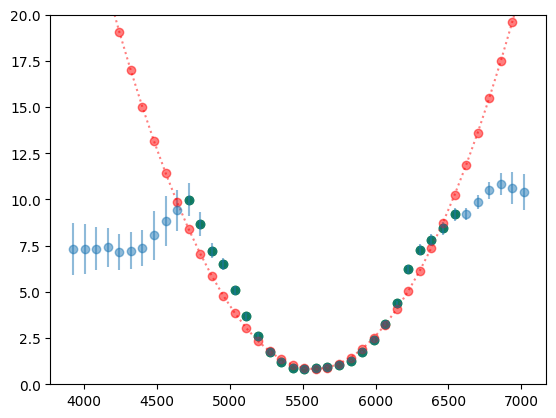

[1.01790567e-05 5.58000000e+03 8.16815964e-01]
[6.71827134e-07 9.83123358e+00 2.36002995e-02]


In [141]:
#plt.scatter(velo[367:383],spectrum_avg_b[367:383],label='data')
plt.scatter(x_forfit,y_forfit,color='green')
plt.errorbar(v_12CO[minchan:maxchan],ratio_12CO_13CO_ave_b[minchan:maxchan],yerr=ratio_12CO_13CO_std_b[minchan:maxchan],label='data', fmt='o', alpha=0.5)
plt.plot(v_12CO[minchan:maxchan],quadratic(v_12CO[minchan:maxchan],*popt_b),'ro:',label='fit',alpha=0.5)
plt.axhline(62,color='r',linestyle='--')
plt.ylim(0,20)
plt.show()
print(popt_b)
print(np.sqrt(np.diagonal(pcov_b)))

1996.4548258443021


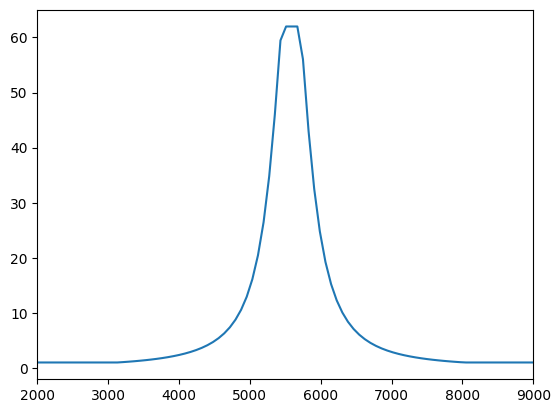

In [142]:

corr_fac12co_b = np.zeros((T_data_12CO.shape[0]),dtype=float)

for i in range(T_data_12CO.shape[0]):
    r = quadratic(v_12CO[i],*popt_b)
    if r < 1.0:
        Ratio = 1.0
    elif r > 62.0:
        Ratio = 62.0
    else:
        Ratio = r
    corr_fac12co_b[i] = 1/(Ratio/X_1213)

plt.plot(v_12CO,corr_fac12co_b)
# plt.hlines(y=1, xmin=-40000,xmax=60000)
plt.xlim(2e3,9e3)
# plt.axvline(x=5560)
print(np.nansum(corr_fac12co_b))

### Right lobe

Channel number of minimum ratio near cloud velocity = 39


array([12.38317688, 13.65435094, 15.36472076, 15.44917413, 15.83332966,
       15.59941933, 15.42680305, 15.91502984, 16.40672889, 15.02999227,
       14.49098278, 13.50615777, 10.0745673 ,  6.00988974,  2.93465289,
        1.4390547 ,  0.7532318 ,  0.47647787,  0.37751909,  0.35264385,
        0.36330257,  0.3865778 ,  0.43460494,  0.48888071,  0.55211872,
        0.67027279,  1.06239945,  2.37863298,  5.09233329,  8.53136896,
       10.91694826, 11.28949604, 11.20083973, 11.30629198, 11.73194578,
       12.00520501, 12.3136911 , 12.28016025, 12.86228849, 13.99276735])

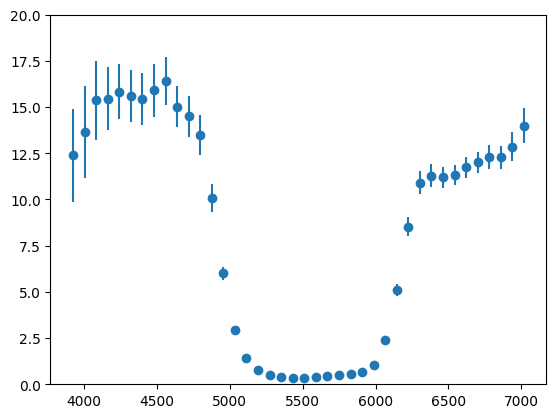

In [143]:
#list values around cloud velocity, get channels (index) by looking at data cube

centralchan = 589 # check cube to see which is central channnel
chanwidth = 20 # number of channels below and above "central" channel
minchan = centralchan - chanwidth
maxchan = centralchan + chanwidth

#first plot them
plt.errorbar(v_12CO[minchan:maxchan],ratio_12CO_13CO_ave_r[minchan:maxchan],yerr=ratio_12CO_13CO_std_r[minchan:maxchan],label='data', fmt='o')
#plt.xlim(6, 10)
plt.ylim(0,20)

# show channel with minimum ration around cloud velocity 
print('Channel number of minimum ratio near cloud velocity =',np.argmin(ratio_12CO_13CO_ave_r[minchan:maxchan])+chanwidth)
#list ratios at velocities 
ratio_12CO_13CO_ave_r[minchan:maxchan]

In [144]:
from scipy.optimize import curve_fit

def quadratic(x,a,b,c):
    return a*(x-b)**2+c

centralchan = 589
x1 = int(centralchan - 12)
x2 = int(centralchan - 4)  #remember in python [x1:x2] means x1 to x2-1
x3 = int(centralchan + 5)
x4 = int(centralchan + 13)

x_forfit = np.concatenate((np.array(v_12CO[x1:x2]), np.array(v_12CO[x3:x4])), axis=0) 
y_forfit = np.concatenate((ratio_12CO_13CO_ave_r[x1:x2], ratio_12CO_13CO_ave_r[x3:x4]), axis=0)
sig_forfit = np.concatenate((ratio_12CO_13CO_std_r[x1:x2], ratio_12CO_13CO_std_r[x3:x4]), axis=0)

popt_r,pcov_r = curve_fit(quadratic,x_forfit,y_forfit,sigma=sig_forfit,p0=[1.0,5500,1.0],bounds=([-np.inf, 5480,-np.inf],[np.inf,5580,np.inf])) #,sigma=sig_forfit


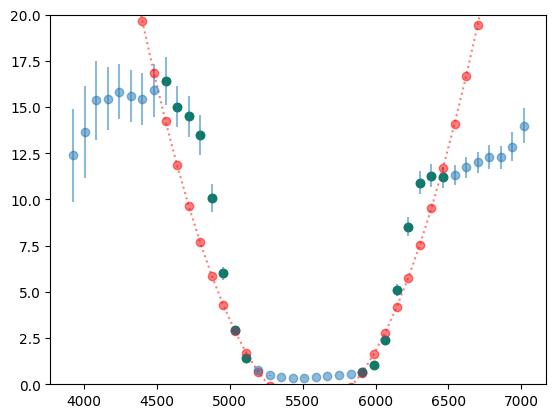

[ 1.57791484e-05  5.55271319e+03 -1.35906352e+00]
[1.79964273e-06 1.21536181e+01 3.16565651e-01]


In [145]:
#plt.scatter(velo[367:383],spectrum_avg_b[367:383],label='data')
plt.scatter(x_forfit,y_forfit,color='green')
plt.errorbar(v_12CO[minchan:maxchan],ratio_12CO_13CO_ave_r[minchan:maxchan],yerr=ratio_12CO_13CO_std_r[minchan:maxchan],label='data', fmt='o', alpha=0.5)
plt.plot(v_12CO[minchan:maxchan],quadratic(v_12CO[minchan:maxchan],*popt_r),'ro:',label='fit',alpha=0.5)
plt.axhline(62,color='r',linestyle='--')
plt.ylim(0,20)
plt.show()
print(popt_r)
print(np.sqrt(np.diagonal(pcov_r)))

2136.3239602684885


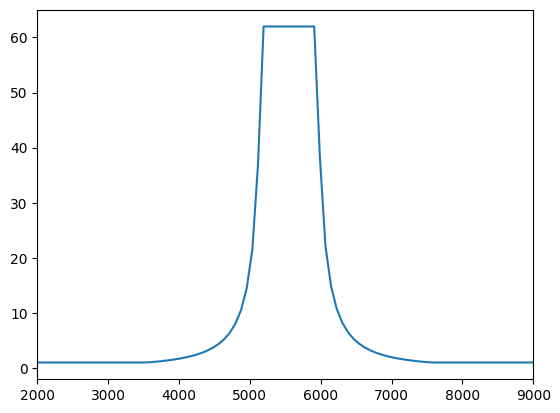

In [146]:

corr_fac12co_r = np.zeros((T_data_12CO.shape[0]),dtype=float)

for i in range(T_data_12CO.shape[0]):
    r = quadratic(v_12CO[i],*popt_r)
    if r < 1.0:
        Ratio = 1.0
    elif r > 62.0:
        Ratio = 62.0
    else:
        Ratio = r
    corr_fac12co_r[i] = 1/(Ratio/X_1213)

plt.plot(v_12CO,corr_fac12co_r)
# plt.hlines(y=1, xmin=-40000,xmax=60000)
plt.xlim(2e3,9e3)
# plt.axvline(x=5560)
print(np.nansum(corr_fac12co_r))

### Opacity correction on cloud subtracted 12CO outflow data

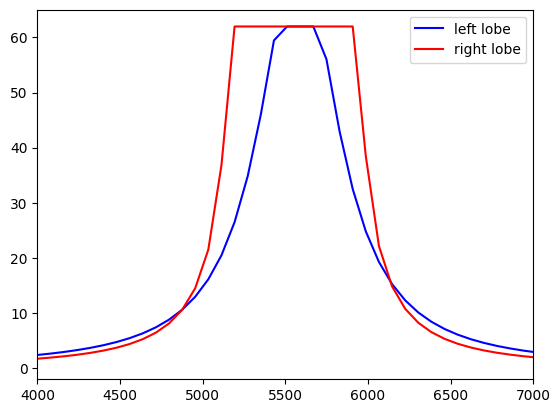

In [147]:
plt.plot(v_12CO,corr_fac12co_b,color='blue',label='left lobe')
plt.plot(v_12CO,corr_fac12co_r,color='red',label='right lobe')
plt.xlim(4e3,7e3)
plt.legend()

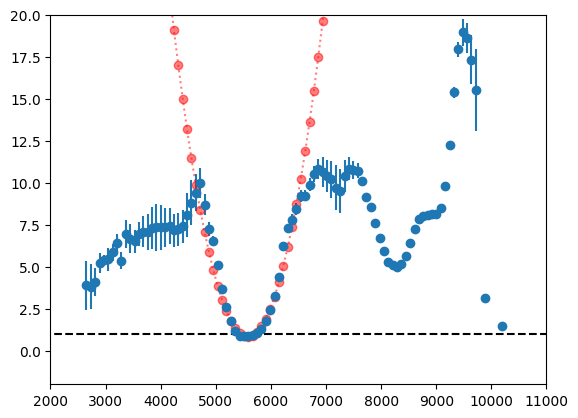

In [148]:
plt.errorbar(v_12CO,ratio_12CO_13CO_ave_b,yerr=ratio_12CO_13CO_std_b,label='data', fmt='o')
plt.plot(v_12CO[35:],quadratic(v_12CO,*popt_b)[35:],'ro:',label='fit',alpha=0.5)
plt.xlim(2e3, 1.1e4)
plt.ylim(-2,20)
plt.hlines(y=1, xmin=1e3, xmax=1.2e4, linestyles='dashed', color='black')

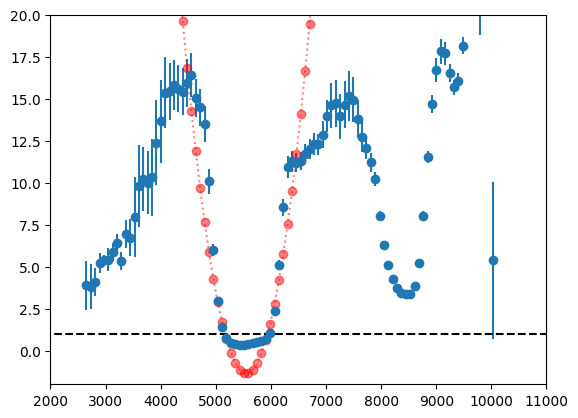

In [149]:
plt.errorbar(v_12CO,ratio_12CO_13CO_ave_r,yerr=ratio_12CO_13CO_std_r,label='data', fmt='o')
plt.plot(v_12CO[35:],quadratic(v_12CO,*popt_r)[35:],'ro:',label='fit',alpha=0.5)
plt.xlim(2e3, 1.1e4)
plt.ylim(-2,20)
plt.hlines(y=1, xmin=1e3, xmax=1.2e4, linestyles='dashed', color='black')

In [150]:
## [INPUT]
## Import the cloud subtracted outflow data (computed from another code)

order_polynomial = 5
num_points = 20
hdul_12CO_outflow_sub = fits.open(dir_data+'/HOPS198/outflow/HOPS198_12CO_outflow_corrected_order'+str(order_polynomial)+'_nrect_'+str(num_points)+'.fits')


hdul_12CO_outflow_sub.info()

hdu_12CO_outflow_sub = hdul_12CO_outflow_sub[0]
cube_12CO_outflow_sub_header = hdu_12CO_outflow_sub.header
cube_12CO_outflow_sub_data = hdu_12CO_outflow_sub.data

Filename: /Users/donglinwu/Desktop/College/Research/HOPS198/outflow/HOPS198_12CO_outflow_corrected_order5_nrect_20.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      79   (448, 448, 1300)   float64   


In [153]:
## T_sub_12CO: brightness temperature of 12CO outflow data

T_sub_12CO = T_mb(cube_12CO_outflow_sub_data,nu_o_12CO, bmaj_12CO,bmin_12CO)

<div style="font-size: 16px; line-height:1.5;">
  
Just like 13CO fits cube, the following chunk of code is incomplete. <br>
vec_dis, region_central, c1_pixel, c2_pixel, mask_rline, mask_lline are defined when the outflow masks are created. However, they are not important here.  <br>
<br>
What the following chunk is doing is to correct the blueshifted and redshifted lobes for opacity using the different factors obtained above. However, to make sure the figure/data is smooth, the central region (overlapping region of the masks of the two lobes) are corrected using an linear interpolation of the correction factor through the region.<br>
<br>

The import thing is to run a loop through all the channels and multiply: brightness temperature of 12CO with the correction factor computed previously.
  
</div>



In [ ]:
## T_corr_12CO: opacity corrected 12CO outflow data

T_corr_12CO = np.zeros(shape=T_data_12CO.shape,dtype=float)

In [154]:
for vchan in range(T_data_12CO.shape[0]):
    vec_dis = np.array([min(dist_central)-2,min(dist_central)-1, max(dist_central)+1,max(dist_central)+2])
    vec_fac_corr = np.array([corr_fac12co_r[vchan],corr_fac12co_r[vchan], corr_fac12co_b[vchan],corr_fac12co_b[vchan]])
    distribution_function = interp1d(vec_dis, vec_fac_corr,kind='cubic')
    fac_corr_central = fill_pixels(region_central, c1_pixel, c2_pixel, distribution_function)
    T_corr_12CO[vchan,:,:] = T_sub_12CO[vchan,:,:]*np.logical_not(mask_rline)*corr_fac12co_b[vchan] + T_sub_12CO[vchan,:,:]*np.logical_not(mask_lline)*corr_fac12co_r[vchan] + T_sub_12CO[vchan,:,:]*mask_lline*mask_rline*fac_corr_central
    # T_corr_12CO[vchan,:,:] = T_sub_12CO[vchan,:,:]*np.logical_not(mask_rline)*corr_fac12co_b[vchan] + T_sub_12CO[vchan,:,:]*np.logical_not(mask_lline)*corr_fac12co_r[vchan] + T_sub_12CO[vchan,:,:]*mask_lline*mask_rline*(corr_fac12co_b[vchan] + corr_fac12co_r[vchan])/2

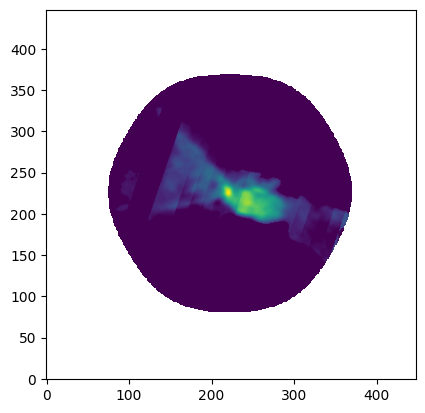

In [155]:
plt.imshow(T_corr_12CO[580,:,:],origin='lower')

In [156]:
from astropy.io import fits

hdu_output = fits.PrimaryHDU()
hdu_output.data = T_corr_12CO
hdu_output.header = hdu_12CO.header
hdu_output.header['BUNIT'] = 'K'
hdu_output.writeto(dir_data+'/HOPS198/outflow/HOPS198_12CO_outflow_opacity_corrected_order'+str(order_polynomial)+'_nrect_'+str(num_points)+'_250522.fits', overwrite=True) #
# hdu_output.writeto(dir_data+'/HOPS198/outflow/HOPS198_12CO_outflow_opacity_not_corrected.fits', overwrite=True) #

## Column density to calculate mass

The general equation for obtaining the total column density of a molecule from a rotational transition from $J+1$ 
to $J$ is:

$N_{tot} = \frac{3 k}{8 \pi^3 B \mu} ~ \frac{1}{J+1} ~ {\mathrm{exp}}[~hBJ(J+1)/kT_{ex} ~] \frac{T_{ex} ~ + ~ hB/3k} {1 - \mathrm{exp}(-h\nu/kT_{ex}~)} ~ ~ ~\int \tau dv$ 

(See Garden et al 1991 ApJ 374, 540)

In the optically thin limit case ($\tau << 1$), then :

$ \int \tau ~dv = \frac{1}{J(~T_{ex}~) - J(~T_{bg}~)} ~ ~\int ~ T_{mb}~ dv $
(see, e.g., Buckle et al. 2010)

Hence in the optically thin limit we can get the total column density as:

$N_{tot} = \frac{3 k}{8 \pi^3 B \mu} ~ \frac{1}{J+1} ~ {\mathrm{exp}}[~hBJ(J+1)/kT_{ex} ~] \frac{T_{ex} ~ + ~ hb/3k} {1 - \mathrm{exp}(-h\nu/kT_{ex}~)} ~ ~ \frac{1}{J(~T_{ex}~) - J(~T_{bg}~)} ~ ~\int ~ T_{mb}~ dv $

where $ J(T) = \frac{T_o}{\mathrm{exp}(~T_o~/~T~) - 1}$

and $T_o = \frac{h\nu}{k}$

$h$ is Planck's constant = $6.6261 \times 10^{-27}$ cm$^2$ g s$^{-1}$

$k$ is Boltzmann's constant = $1.3807 \times 10^{-16}$ cm$^2$ g s$^{-2}$ K$^{-1}$

For 12CO(2-1), then:

$J = 1$ 

$B = 57635.968$ MHz

$\mu = 0.11011$ Debye

$\nu = 230.5380$ GHz

$T_o = 11.06$

$$
\begin{array}{c}
N\left(^{12}\mathrm{CO}\right)= 1.95 \times 10^{14} \exp(5.532/T_{\mathrm{ex}}) \frac{T_{\mathrm{ex}}+0.922}{1-\exp \left(-11.06 / T_{\mathrm{ex}}\right)} ~ ~ \frac{1}{J\left(T_{\mathrm{ex}}~ ~ \right)-J\left(T_{\mathrm{bg}}~ ~\right)}  ~ ~ \int T_{\mathrm{mb}}\left(^{12}\mathrm{CO}\right) d v
\end{array}
$$

$T_{bg} = 2.725$ K

In [159]:
## [FUNCTION]
## Function J in the equation above
def J(T, nu):
    # T: temperature in K
    # nu: frequency in Hz
    return h*nu/k/(math.exp(h*nu/(k*T))-1)

In [160]:
## [FUNCTION]
## Function that computes the prefactor before the integral of brightness temperature over the frequency

def c_N12CO(T_ex, T_bg, nu):
    # column density (in cm^-2) = c_NC18O * integral of brightness temperature over velocity
    '''chanw: channel width in m/s'''
    #print('1')
    #print(1/J(v,TEX))
    #print('2')
    arg1 = 1.95*10**14*np.e**(5.532/T_ex)
    return arg1*((T_ex+0.922)/(1.0-np.exp(-11.06/T_ex)))*(1/(J(T_ex, nu)-J(T_bg, nu)))/1000

In [161]:
## [FUNCTION]
## Function that computes the column density of 12CO

def func_N12CO(vec_T, T_ex, T_bg, nu, dv):
    # dv in m/s
    # column density in cm^-2
    return c_N12CO(T_ex, T_bg, nu)*np.nansum(vec_T)*dv

In [162]:
## N_12CO: 2d array for the column density of 12CO 

N_12CO = np.zeros((T_data_12CO.shape[1],T_data_12CO.shape[2]),dtype=float)
for xchan in range(T_data_12CO.shape[2]):
    for ychan in range(T_data_12CO.shape[1]):
        N_12CO[ychan, xchan] = func_N12CO(T_corr_12CO[400:800,ychan,xchan], 50, 2.725, nu_o_12CO, dv_12CO)

In [165]:
## N_H2: 2d array for the column density of H2

N_H2 = N_12CO/X_12CO

In [ ]:
## [FUNCTION]
## Function that computes the area of each pixel in squared cm
def A_pixel(d_source, dx_pixel, dy_pixel):
    # d_source in parsec
    # dx_pixel, dy_pixel: length and width of pixel in degrees
    # returns area of pixel in cm^2
    return abs(dx_pixel*dy_pixel)*pow(u.parsec.to(u.cm),2)*pow(pi/180, 2)*pow(d_source,2)

## d_source: distance to the source in parsec
d_source = 386 # 386.0 for HOPS 198

m_mol_H2 = 1.00784*const.u.value #hydrogen atom mass in kg
mu_H2 = 2.8 #mean molecular weight of H2

In [166]:
## M_outflow_pixel: an image (2d array) for the mass of the outflow in each pixel in solar mass
M_outflow_pixel = mu_H2*m_mol_H2*A_pixel(d_source, dx_12CO, dy_12CO)*N_H2  #mass of outflow in each pixel in kg
M_outflow_pixel = M_outflow_pixel/const.M_sun.value
M_outflow = np.nansum(M_outflow_pixel) #mass of core in the entire image in solar mass
print(M_outflow)
# print(np.nansum(M_outflow_pixel*mask_outflow))

0.037516369838053176


(90.0, 358.0)

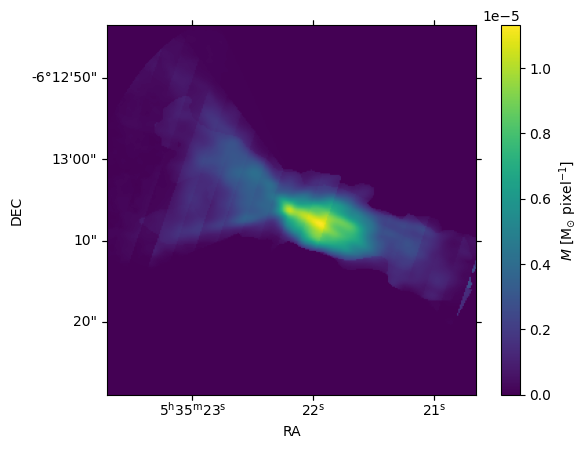

In [141]:
plt.figure()
plt.subplot(projection=wcs_12CO[0,:,:])
plt.imshow(M_outflow_pixel, origin='lower')
plt.colorbar(label=r'$M$ [M$_{\odot}$ pixel$^{-1}$]')

# for aperture_pix in apertures_pix:
#     aperture_pix.plot(color='black')

# plt.contour(mask_12CO_13CO_b)
# plt.contour(mask_12CO_13CO_r)
# plt.contour(mask_lline, linewidths=0.1)

plt.xlabel('RA')
plt.ylabel('DEC')
plt.xlim(90,448-90)
plt.ylim(90,448-90)

In [143]:
## [OPTIONAL]
## Save the mass of the outflow into a fits file

# from astropy.io import fits

# hdu_output = fits.PrimaryHDU()
# hdu_output.data = M_outflow_pixel
# for i in range(len(list(hdu_12CO.header.keys()))):
#     key = list(hdu_12CO.header.keys())[i]
#     if '3' not in key and 'COMMENT' not in key and 'HISTORY' not in key:
#         print(key)
#         hdu_output.header.update({key:hdu_12CO.header[key]})

# hdu_output.header.update({'NAXIS':2})
# hdu_output.header['BUNIT'] = 'solMass'
# hdu_output.writeto(dir_data+'/HOPS198/outflow/HOPS198_12CO_outflow_mass_order'+str(order_polynomial)+'_nrect_'+str(num_points)+'.fits', overwrite=True)


SIMPLE
BITPIX
NAXIS
NAXIS1
NAXIS2
EXTEND
BSCALE
BZERO
BMAJ
BMIN
BPA
BTYPE
OBJECT
BUNIT
EQUINOX
RADESYS
LONPOLE
LATPOLE
PC1_1
PC2_1
PC1_2
PC2_2
CTYPE1
CRVAL1
CDELT1
CRPIX1
CUNIT1
CTYPE2
CRVAL2
CDELT2
CRPIX2
CUNIT2
PV2_1
PV2_2
RESTFRQ
SPECSYS
ALTRVAL
ALTRPIX
VELREF
TELESCOP
OBSERVER
DATE-OBS
TIMESYS
OBSRA
OBSDEC
OBSGEO-X
OBSGEO-Y
OBSGEO-Z
INSTRUME
DISTANCE
USEWEIGH
DATE
ORIGIN
